# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from datetime import datetime as dt


import warnings

warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## General data inspection

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


* Events in transcript dataset

In [5]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

* Missing values in profiles dataset

In [6]:
np.sum(profile.isna())

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

* Gender count in profile dataset

In [7]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

* Age count in profile dataset

In [8]:
profile.age.value_counts().head(6)

118    2175
58      408
53      372
51      363
54      359
59      359
Name: age, dtype: int64

* Desciptive statistics of the income variable

In [9]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

* Desciptive statistics of the age variable

In [10]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

* Desciptive statistics of the female gender

In [11]:
profile[profile['gender']=='F'].describe()

,age,became_member_on,income
count,6129.000000,6.129000e+03,6129.000000
mean,57.544950,2.016704e+07,71306.412139
std,16.883315,1.063408e+04,22338.353773
min,18.000000,2.013073e+07,30000.000000
25%,48.000000,2.016061e+07,54000.000000
50%,58.000000,2.017062e+07,71000.000000
75%,69.000000,2.017121e+07,88000.000000
max,101.000000,2.018073e+07,120000.000000


* Desciptive statistics of the male gender

In [12]:
profile[profile['gender']=='M'].describe()

,age,became_member_on,income
count,8484.000000,8.484000e+03,8484.000000
mean,52.116690,2.016675e+07,61194.601603
std,17.413894,1.272796e+04,20069.517615
min,18.000000,2.013073e+07,30000.000000
25%,39.000000,2.016043e+07,45000.000000
50%,53.000000,2.017082e+07,59000.000000
75%,65.000000,2.018011e+07,73000.000000
max,100.000000,2.018073e+07,120000.000000


* Desciptive statistics of the other gender

In [13]:
profile[profile['gender']=='O'].describe()

,age,became_member_on,income
count,212.000000,2.120000e+02,212.000000
mean,54.400943,2.016790e+07,63287.735849
std,16.244710,1.119045e+04,18938.594726
min,20.000000,2.013092e+07,30000.000000
25%,43.000000,2.016073e+07,51000.000000
50%,55.000000,2.017081e+07,62000.000000
75%,66.000000,2.018011e+07,79250.000000
max,100.000000,2.018072e+07,100000.000000


## Data visualisation

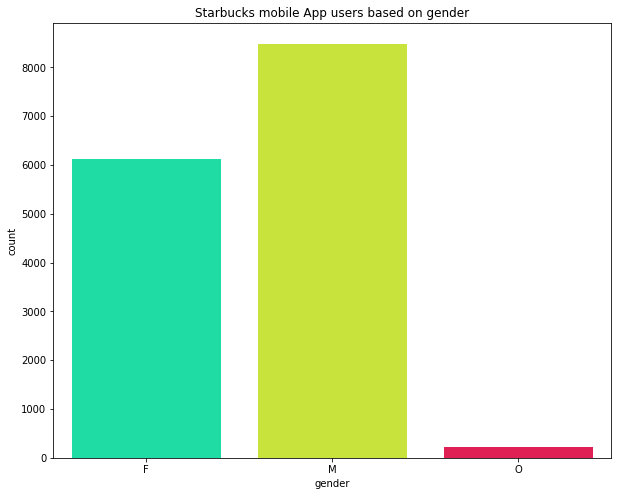

In [14]:
plt.figure(figsize=(10, 8))
sns.countplot(x="gender", data=profile,palette='gist_ncar')
plt.title('Starbucks mobile App users based on gender');

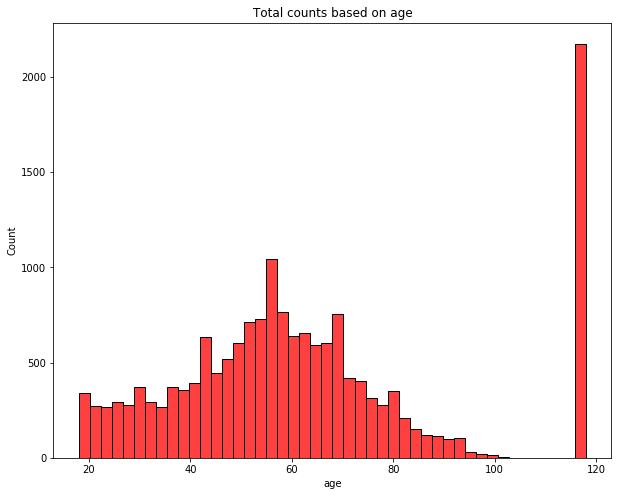

In [15]:
plt.figure(figsize=(10, 8))
sns.histplot(x="age", data=profile, color ='r');
plt.title('Total counts based on age');

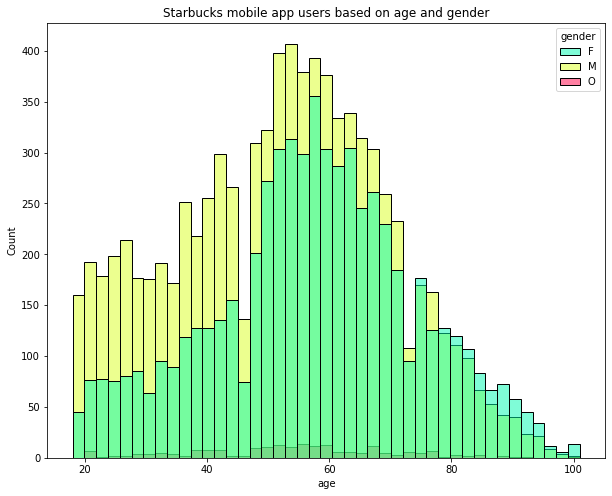

In [16]:
plt.figure(figsize=(10, 8))
sns.histplot(x="age", hue="gender", data=profile,palette = 'gist_ncar')
plt.title('Starbucks mobile app users based on age and gender');

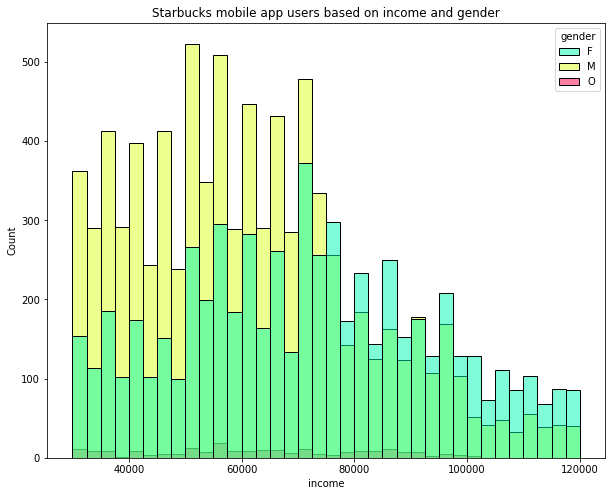

In [17]:
plt.figure(figsize=(10, 8))
sns.histplot(x="income", hue="gender", data=profile,palette = 'gist_ncar')
plt.title('Starbucks mobile app users based on income and gender');

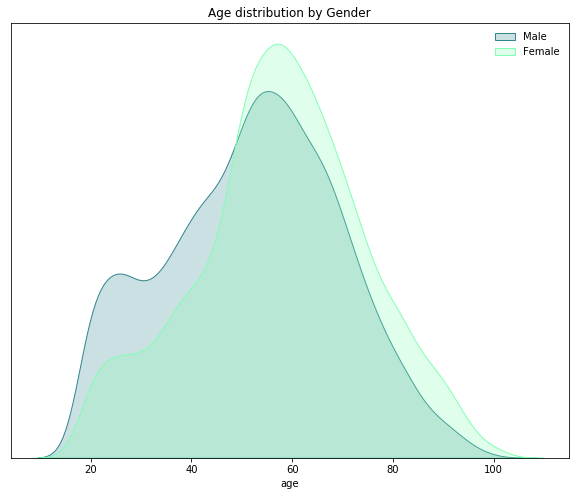

In [18]:
Males = profile[profile['gender']=='M']
Females = profile[profile['gender']=='F']
plt.figure(figsize=(10, 8))
sns.kdeplot(data=Males, x="age", hue='gender',fill=True, palette="crest")
sns.kdeplot(data=Females, x="age", hue='gender',fill=True, palette="rainbow")
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);

# Transform transcript
* Preprocess the transcript dataset
* Extract information from the value column

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
def transcript_redefined(df=transcript):
    '''
    Function to clean transcript data
    
    Input:
    df - DataFrame: Transcript data
    
    Output:    
    df:DataFrame  - Tranformed variables of the transcript data frame 
    df.Columns    - event,customer_id,offer_id,amount,reward,offer_days.  
    '''
    # Create a new dataframe from the original transcript dataframe comprising of 'person'&'value'
    df1 = df[['person','value']]
    
    # Seperate the 'amounts' and the 'rewards'
    vals = df1['value'].apply(lambda a: pd.Series(a))
    
    # Convert the series into a dataframe
    df2 = pd.DataFrame(vals, index=df1.index).join(df1)
    
    # Add NaNs in column 'offer id' where row in column 'offer_id' is NaN.
    df2['offer id'].fillna(df2['offer_id'], inplace=True)
    
    # Drop the original 'offer_id' and 'person' columns
    df2 = df2.drop(['offer_id','person'], axis=1)
    
    # Merge the original dataframe with transformed df1(i.e df2)
    df_new = pd.concat([df, df2], axis=1)
    df_new = df_new.drop('value', axis=1)
        
    #Create a column that shows the number of days since start of test.
    df_new['offer_days'] = (df_new['time'] / 24).round(0)
    df_new = df_new.drop('time', axis=1)
    
    df_new.rename(columns={"person": "customer_id", "offer id": "offer_id"}, inplace=True)
    
    return df_new    

In [21]:
transcript_df = transcript_redefined(transcript)

In [22]:
transcript_df.head()

,event,customer_id,offer_id,amount,reward,offer_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0.0


# Portfolio
* Preprocess the profile dataset
* Split the channels columns into new variables

In [23]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [24]:
def preprocess_portfolio(df = portfolio):
    
    '''
    Function to clean the portoflio dataset.
    
    Input:
    df: DataFrame - Portfolio dataframe
    
    Output:
    df: DataFrame - Portfolio dataframe with categorical variables handled.
                    Columns == 'difficulty','duration','offer_id','offer_type','email','mobile','social','web'          
    '''   
    # Create columns for the individual channels and convert them to dummy variables.
    
    # Create the Email column of 1s and 0s
    df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
    
    # Create the Mobile column of 1s and 0s
    df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    
    # Create the Social column of 1s and 0s 
    df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # Create the Web column of 1s and 0s
    df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    # Drop  the original channels column
    df = df.drop('channels', axis=1)
    
    # Rename the id column.
    df.rename(columns={'id':'offer_id'},inplace=True)
    
    return df
portfolio_df = preprocess_portfolio(portfolio)

In [25]:
portfolio_df

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


# Profile
* Preprocess the profile dataset
* Transform the memebership_start column into other features

In [26]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [27]:
def preprocess_profile(df=profile):
    '''
    Function to clean the profile dataset.
    -------------------------------------------------------------
    Input:
    df: DataFrame - Portfolio dataframe
    -------------------------------------------------------------
    Output:
    df: DataFrame - Transformed varibales of the porfolio dataframe
    df.columns = age,gender,customer_id,income,membership_start,year,month and membership_term.
    
    '''
    
    # Transform date column to datetime
    df['membership_start'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    
    # Extract the year one became a member
    df['year'] = pd.DatetimeIndex(df['membership_start']).year
    
    # Extract the month one became a member
    df['month'] = pd.DatetimeIndex(df['membership_start']).month
    
    # Rename the id column
    df.rename(columns={'id':'customer_id'},inplace=True)
    
    #Extract the number of days a user has been a member of the rewards app.
    today = pd.to_datetime(dt.today().strftime('%Y%m%d'))
    df['membership_term'] = (today - df['membership_start']).dt.days
    
    df = df.drop('became_member_on', axis=1)
    return df

In [28]:
profile_df = preprocess_profile(profile)

In [29]:
profile_df.head()

,age,gender,customer_id,income,membership_start,year,month,membership_term
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017,2,1600
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,7,1447
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018,7,1085
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,5,1514
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017,8,1427


## Define the status of the offer
* offer can be successful if product of complete & view > 0
* offer is unsuccessful if product of complete & view is 0

In [30]:
def find_offer_status(df = transcript_df):
    '''
    Function to transform transcript dataframe to return a 
    dataframe where it shows each successful and unsuccesful offer.
    -------------------------------------------------------------
    Input:
    df: DataFrame - Transfromred transcript dataframe 
    --------------------------------------------------------------
    Output:
    offer_status:DataFrame - matches the customer_id,offer_id and offer status.
     
    '''
    # Group the 
    offer_status = df.groupby(['customer_id','offer_id','event'])['offer_days'].count().unstack()
    
    offer_status.reset_index(level=[0,1],inplace = True)
    
    #Replace nan values with 0.0
    
    offer_status.fillna(0.0, inplace = True)
    
    # Find successful offers i.e where offer completed and offer viewed  are greater than 1.
    # To find successful offers,offer completed and offer viewed are multiplied
    # Replace any values greater than 0 with 1  
    # This is an important step as some offers are completed but have not been viewed - meaning the offer did not cause the 
    #transaction.
    
    offer_status['success'] = offer_status['offer completed'] * offer_status['offer viewed']
    
    offer_status['success'] = offer_status['success'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
    offer_status.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)
                                                        
                
    return offer_status

status = find_offer_status(transcript_df)

In [31]:
status.head()

event,customer_id,offer_id,success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0


## Merge the preprocessed dataset
* Merge the profile, portfolio and status dataframe into one

In [32]:

def merge_dataframes(profile_df,portfolio_df,status):
    
    '''
    Function to merge all the dataframes together.
    -----------------------------------------------
    Input:
    profile_df: DataFrame   - cleaned profile dataframe
    portfolio_df: DataFrame - cleaned porfolio dataframe 
    status: DataFrame       - success or failure of an offer
    -----------------------------------------------
    Output:
    df_all: DataFrame - Aggregated variables in the profile and porfolio dataframes with the status dataframe.
    df_all.columns    - customer_id,offer_id,success,difficulty,duration,offer_type,reward,email,mobile,social,web,
                        age,gender,income,membership_start,year,month,membership_term       
    '''
    # Merge the status dataframe with the cleaned portfolio dataframe.
    df_all = status.merge(portfolio_df,how='left',on='offer_id')
    
    # Merge the merge status and portfolio dataframe with the profile dataframe.
    df_all = df_all.merge(profile_df,how='left',on='customer_id')
    
    # rename offer_ids to a more readable format.    
    unique_offers =  list(df_all['offer_id'].unique())
    
    for i in range(len(unique_offers)):
        
        df_all['offer_id'] = df_all['offer_id'].apply(lambda x: f'Offer- {i+1}' if x == unique_offers[i] else x)
    
    return df_all

df_all = merge_dataframes(profile_df,portfolio_df,status)

df_all.head(10)

,customer_id,offer_id,success,difficulty,duration,offer_type,reward,email,mobile,social,web,age,gender,income,membership_start,year,month,membership_term
0,0009655768c64bdeb2e877511632db8f,Offer- 1,0.0,10,7,discount,2,1,1,0,1,33,M,72000.0,2017-04-21,2017,4,1532
1,0009655768c64bdeb2e877511632db8f,Offer- 2,0.0,0,4,informational,0,1,1,0,1,33,M,72000.0,2017-04-21,2017,4,1532
2,0009655768c64bdeb2e877511632db8f,Offer- 3,0.0,0,3,informational,0,1,1,1,0,33,M,72000.0,2017-04-21,2017,4,1532
3,0009655768c64bdeb2e877511632db8f,Offer- 4,1.0,5,5,bogo,5,1,1,1,1,33,M,72000.0,2017-04-21,2017,4,1532
4,0009655768c64bdeb2e877511632db8f,Offer- 5,1.0,10,10,discount,2,1,1,1,1,33,M,72000.0,2017-04-21,2017,4,1532
5,00116118485d4dfda04fdbaba9a87b5c,Offer- 4,0.0,5,5,bogo,5,1,1,1,1,118,None,NaN,2018-04-25,2018,4,1163
6,0011e0d4e6b944f998e987f904e8c1e5,Offer- 6,1.0,20,10,discount,5,1,0,0,1,40,O,57000.0,2018-01-09,2018,1,1269
7,0011e0d4e6b944f998e987f904e8c1e5,Offer- 7,1.0,7,7,discount,3,1,1,1,1,40,O,57000.0,2018-01-09,2018,1,1269
8,0011e0d4e6b944f998e987f904e8c1e5,Offer- 2,0.0,0,4,informational,0,1,1,0,1,40,O,57000.0,2018-01-09,2018,1,1269
9,0011e0d4e6b944f998e987f904e8c1e5,Offer- 3,0.0,0,3,informational,0,1,1,1,0,40,O,57000.0,2018-01-09,2018,1,1269


### Define the success and failure dataframes

### Success dataframe contains rows with success = 1
* We exclude the age group = 118 as an outlier

In [33]:
df_success = df_all[(df_all['success'] == 1)& (df_all['age'] < 118)]

In [34]:
df_success.shape[0]

23499

### failure dataframe contains rows with success = 0
* We exclude the age group = 118 as an outlier

In [35]:
df_failure = df_all[(df_all['success'] == 0)& (df_all['age'] < 118)]

In [36]:
df_failure.shape[0]

31723

## Function to count categorical variables

In [37]:
def cat_counts(df,col):
    '''
    Function performs counts and calculates percentage shares of categorical columns
    -----------------------------------------------------------------
    Input:
    df - Dataframe [obj]
    col - categorical column[bool,str]
    -----------------------------------------------------------------
    Output:
    dff - Dataframe consisting of 2 columns (COUNTS & PERCENTAGES)   
    '''
    df[col].value_counts()
    _dict = df[col].value_counts().to_dict()
    _list=[]
    for key, value in _dict.items():
        temp = [key,value]
        _list.append(temp)
    dff = pd.DataFrame(_list, columns=[col,'Count'])
    dff['Perc'] = dff['Count']/np.sum(dff['Count'])*100
    
    return dff

## Function to perform statistical -Categorical & numeric vairable

In [38]:
def stats_description(df, col1, col2):
    '''
    Function performs counts on categorical and numeric variables
    ------------------------------------------------------------
    Input: 
    df - dataframe
    Col1 = categorical column in the df
    col2 = numeric column column in the df
    --------------------------------------------------------------
    output: 
    sats_summary: DataFrame - statistical summary of features of col1 in relation col2
    Sats_summary columns = Mean, median, standard deviation(std),maximum, minimum, 5th & 95th percentile,
                            count of col1 and percentage share of col1
    --------------------------------------------------------------------
    Steps:
    1. Group the dataframe by the categorical variable in relation to a numeric varible.
    2. Perform operation on the groupby dataframe (mean, median,std,max,min, quantiles([.5,95]))
    3. Perform a count on the categorical column(col1) and calculate the percentage.
    4. Merge all the statistcial features into a new dataframe
    '''   
    dict1 = df.groupby(col1)[col2].mean().to_dict()
    dict2 = df.groupby(col1)[col2].median().to_dict()
    dict3 = df.groupby(col1)[col2].std().to_dict()
    dict4 = df.groupby(col1)[col2].max().to_dict()
    dict5 = df.groupby(col1)[col2].min().to_dict()
    dict6 = df.groupby(col1)[col2].quantile(.5).to_dict()
    dict7 = df.groupby(col1)[col2].quantile(.95).to_dict()
    dicts = [dict1, dict2, dict3, dict4, dict5,dict6,dict7]
    result_dict = {}
    for d in dicts:
        for k, v in d.items():
            try:
                result_dict.setdefault(k,[]).extend(v)
            except TypeError:
                result_dict[k].append(v)
    
    sats_summary = pd.DataFrame(result_dict, index = ['mean_' + col2, 'median_' + col2, 'std_' + col2, 'max_' + col2, 'min_' + col2, 
                                                      '5th perc_' + col2 ,'95th perc_' + col2 ]).T
    
    return sats_summary

## Offer_id success and failure rates -General summary

In [39]:
offer_success = cat_counts(df_success,'offer_id')
offer_success.rename(columns = {'Count':'Success_','Perc':'% Success'},inplace=True)
offer_success

,offer_id,Success_,% Success
0,Offer- 5,4154,17.677348
1,Offer- 7,4062,17.285842
2,Offer- 4,3481,14.813396
3,Offer- 10,2813,11.970722
4,Offer- 9,2805,11.936678
5,Offer- 8,2397,10.200434
6,Offer- 1,2335,9.936593
7,Offer- 6,1452,6.178986


In [40]:
offer_failure = cat_counts(df_failure,'offer_id')
offer_failure.rename(columns = {'Count':'Failed_','Perc':'% Failed'},inplace=True)
offer_failure

,offer_id,Failed_,% Failed
0,Offer- 2,5524,17.413233
1,Offer- 3,5517,17.391167
2,Offer- 6,4136,13.037859
3,Offer- 1,3145,9.913943
4,Offer- 8,3145,9.913943
5,Offer- 10,2751,8.671941
6,Offer- 9,2706,8.530089
7,Offer- 4,1964,6.191092
8,Offer- 7,1445,4.555055
9,Offer- 5,1390,4.381679


## visualize the success and failure counts

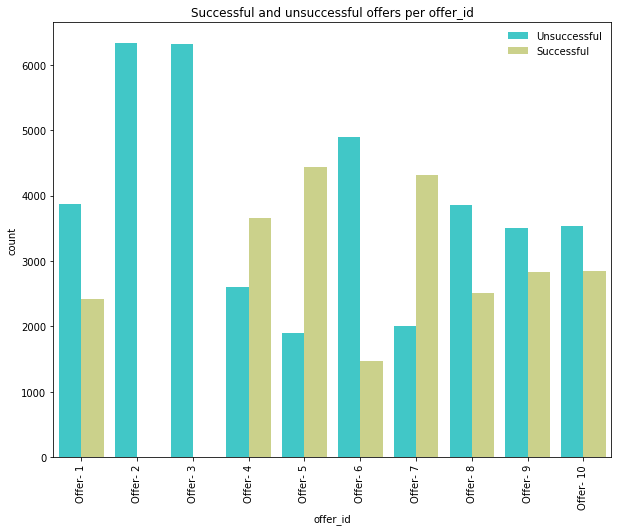

In [41]:
plt.figure(figsize=(10, 8))
sns.countplot(x='offer_id',hue='success',data=df_all,palette='rainbow');
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('Successful and unsuccessful offers per offer_id')
plt.xticks(rotation=90);

# How demographics affect the success rate of an offer.
* Gender
* Income
* Age

# 1. Gender

## Offer success and failure by gender - general summary

In [42]:
success_by_gender = cat_counts(df_success,'gender')
success_by_gender

,gender,Count,Perc
0,M,12102,51.500064
1,F,11004,46.827525
2,O,393,1.672412


In [43]:
failure_by_gender = cat_counts(df_failure,'gender')
failure_by_gender

,gender,Count,Perc
0,M,19543,61.605145
1,F,11804,37.209596
2,O,376,1.185260


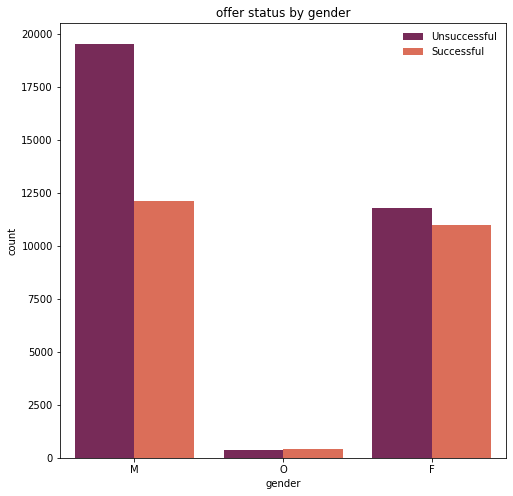

In [44]:
plt.figure(figsize=(8, 8))
sns.countplot(x='gender',hue='success',data=df_all,palette='rocket');
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('offer status by gender');

## offer_id success based on Gender

* Use the cat_count function to perform counts per gender and offer_id
* merge the gender dataframes into 1

### gender - success

In [45]:
offer_success_Females = cat_counts(df_success[df_success['gender']=='F'],'offer_id')
offer_success_Females.rename(columns = {'Count':'Famale_','Perc':'% Female'},inplace=True)
offer_success_males = cat_counts(df_success[df_success['gender']=='M'],'offer_id')
offer_success_males.rename(columns = {'Count':'Male_','Perc':'% Male'},inplace=True)
offer_success_others = cat_counts(df_success[df_success['gender']=='O'],'offer_id')
offer_success_others.rename(columns = {'Count':'Others_','Perc':'% Others'},inplace=True)
merged_Frame_success = pd.merge(offer_success_Females, offer_success_males, on = 'offer_id', how='inner')
success_gender = pd.merge(merged_Frame_success,offer_success_others, on = 'offer_id', how='inner')
success_gender

,offer_id,Famale_,% Female,Male_,% Male,Others_,% Others
0,Offer- 5,1833,16.657579,2267,18.732441,54,13.740458
1,Offer- 7,1817,16.512177,2184,18.046604,61,15.521628
2,Offer- 4,1607,14.603780,1817,15.014047,57,14.503817
3,Offer- 9,1454,13.213377,1310,10.824657,41,10.432570
4,Offer- 10,1419,12.895311,1348,11.138655,46,11.704835
5,Offer- 8,1125,10.223555,1218,10.064452,54,13.740458
6,Offer- 1,1075,9.769175,1216,10.047926,44,11.195929
7,Offer- 6,674,6.125045,742,6.131218,36,9.160305


### gender - failure

In [46]:
offer_failure_Females = cat_counts(df_failure[df_failure['gender']=='F'],'offer_id')
offer_failure_Females.rename(columns = {'Count':'Famale_','Perc':'% Female'},inplace=True)
offer_failure_males = cat_counts(df_failure[df_failure['gender']=='M'],'offer_id')
offer_failure_males.rename(columns = {'Count':'Male_','Perc':'% Male'},inplace=True)
offer_failure_others = cat_counts(df_failure[df_failure['gender']=='O'],'offer_id')
offer_failure_others.rename(columns = {'Count':'Others_','Perc':'% Others'},inplace=True)
merged_Frame_failure = pd.merge(offer_failure_Females, offer_failure_males, on = 'offer_id', how='inner')
failure_gender = pd.merge(merged_Frame_failure,offer_failure_others, on = 'offer_id', how='inner')
failure_gender

,offer_id,Famale_,% Female,Male_,% Male,Others_,% Others
0,Offer- 3,2313,19.595053,3122,15.975029,82,21.808511
1,Offer- 2,2288,19.383260,3155,16.143888,81,21.542553
2,Offer- 6,1657,14.037614,2438,12.475055,41,10.904255
3,Offer- 1,1190,10.081328,1926,9.855191,29,7.712766
4,Offer- 8,1170,9.911894,1943,9.942179,32,8.510638
5,Offer- 10,869,7.361911,1850,9.466305,32,8.510638
6,Offer- 9,813,6.887496,1872,9.578877,21,5.585106
7,Offer- 4,640,5.421891,1304,6.672466,20,5.319149
8,Offer- 7,439,3.719078,986,5.045285,20,5.319149
9,Offer- 5,425,3.600474,947,4.845725,18,4.787234


### Visualize the offer success based on gender

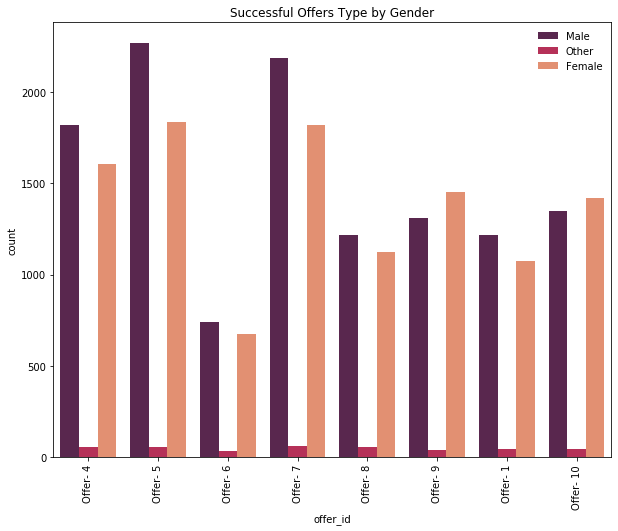

In [47]:
plt.figure(figsize=(10, 8))
sns.countplot(x='offer_id',hue='gender',data=df_success,palette='rocket');
plt.legend(['Male','Other','Female'],frameon=False)
plt.title('Successful Offers Type by Gender')
plt.xticks(rotation=90);

### Visualize the offer failure based on gender

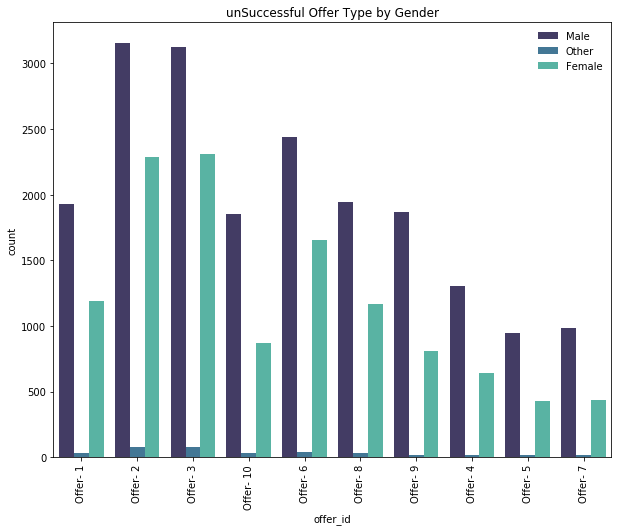

In [48]:
plt.figure(figsize=(10, 8))
sns.countplot(x='offer_id',hue='gender',data=df_failure,palette='mako');
plt.legend(['Male','Other','Female'],frameon=False)
plt.title('unSuccessful Offer Type by Gender')
plt.xticks(rotation=90);

### offer_type success based on Gender

* Use the cat_count function to perform counts per gender and offer_type
* merge the gender dataframes into 1 for comparison.

In [49]:
offertype_success_Females = cat_counts(df_success[df_success['gender']=='F'],'offer_type')
offertype_success_Females.rename(columns = {'Count':'Famale_','Perc':'% Female'},inplace=True)
offertype_success_males = cat_counts(df_success[df_success['gender']=='M'],'offer_type')
offertype_success_males.rename(columns = {'Count':'Male_','Perc':'% Male'},inplace=True)
offertype_success_others = cat_counts(df_success[df_success['gender']=='O'],'offer_type')
offertype_success_others.rename(columns = {'Count':'Others_','Perc':'% Others'},inplace=True)
merged_Frame_success_type = pd.merge(offertype_success_Females, offertype_success_males, on = 'offer_type', how='inner')
success_gender_type = pd.merge(merged_Frame_success_type,offertype_success_others, on = 'offer_type', how='inner')
success_gender_type

,offer_type,Famale_,% Female,Male_,% Male,Others_,% Others
0,bogo,5605,50.936023,5693,47.041811,198,50.381679
1,discount,5399,49.063977,6409,52.958189,195,49.618321


<Figure size 432x288 with 0 Axes>

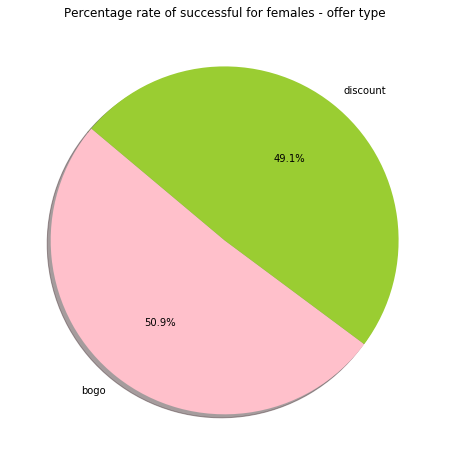

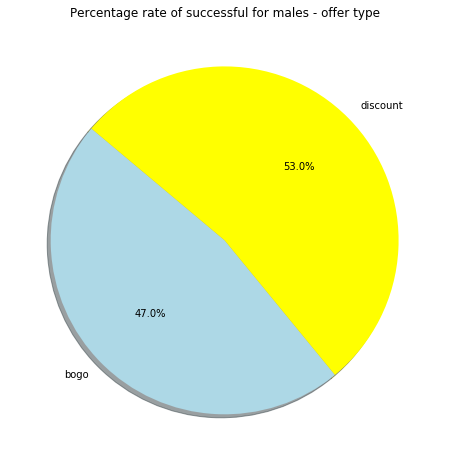

In [50]:
# Visualize the percentage share
labels = success_gender_type['offer_type']
sizes = success_gender_type['Famale_']
colors = ['pink', 'yellowgreen']
#explode = (0.1, 0, 0)  # explode 1st slice

# Pie-chart
plt.figure(0)
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage rate of successful for females - offer type');

plt.figure(1)
labels = success_gender_type['offer_type']
sizes = success_gender_type['Male_']
colors = ['lightblue', 'yellow']
#explode = (0.1, 0, 0)  # explode 1st slice

# Pie-chart
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage rate of successful for males - offer type');

# 2. Income

##  Statistcial summary - Gender & income
* Success

In [51]:
success_income_F_stats = stats_description(df_success,'gender','income')
success_income_F_stats

,mean_income,median_income,std_income,max_income,min_income,5th perc_income,95th perc_income
F,72749.182116,72000.0,21631.966911,120000.0,30000.0,72000.0,110000.0
M,65772.269046,64000.0,20289.729316,120000.0,30000.0,64000.0,100000.0
O,66002.544529,65000.0,18247.798124,100000.0,30000.0,65000.0,95000.0


* Failure

In [52]:
failure_income_F_stats = stats_description(df_failure,'gender','income')
failure_income_F_stats

,mean_income,median_income,std_income,max_income,min_income,5th perc_income,95th perc_income
F,69785.327008,70000.0,22981.189090,120000.0,30000.0,70000.0,110000.0
M,58449.419229,56000.0,19480.600490,120000.0,30000.0,56000.0,96000.0
O,59625.000000,57000.0,19075.018567,100000.0,30000.0,57000.0,91250.0


## Success rate based on gender and income

In [53]:
df_success_F = df_success[df_success['gender']=='F']
df_success_M = df_success[df_success['gender']=='M']
df_success_O = df_success[df_success['gender']=='O']

In [54]:
df_failure_F = df_failure[df_failure['gender']=='F']
df_failure_M = df_failure[df_failure['gender']=='M']
df_failure_O = df_failure[df_failure['gender']=='O']

* Females -Count

In [55]:
success_rate_income_F = cat_counts(df_success_F,'income')
success_rate_income_F.sort_values('Count',ascending=False).head(10)

,income,Count,Perc
0,72000.0,246,2.235551
1,71000.0,243,2.208288
2,73000.0,238,2.162850
3,75000.0,225,2.044711
4,74000.0,224,2.035623
5,87000.0,220,1.999273
6,57000.0,205,1.862959
7,58000.0,202,1.835696
9,85000.0,190,1.726645
10,53000.0,190,1.726645


In [56]:
failure_rate_income_F = cat_counts(df_failure_F,'income')
failure_rate_income_F.sort_values('Count',ascending=False).head(10)

,income,Count,Perc
0,71000.0,258,2.185700
1,75000.0,244,2.067096
2,74000.0,243,2.058624
3,73000.0,243,2.058624
4,72000.0,228,1.931549
5,70000.0,213,1.804473
6,60000.0,209,1.770586
7,57000.0,203,1.719756
8,61000.0,200,1.694341
9,54000.0,190,1.609624


* Females -statistical description -Success

### Visualize the distributions

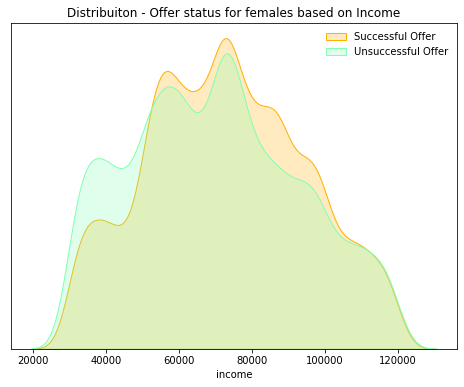

In [57]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_success_F, x="income", hue='success',fill=True,palette='prism_r')
sns.kdeplot(data=df_failure_F, x="income", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Distribuiton - Offer status for females based on Income');

### Visualize the counts

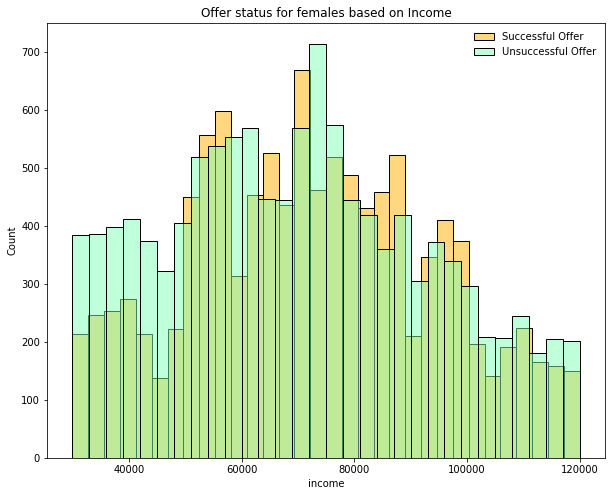

In [58]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_success_F, x="income", hue='success',fill=True,palette='prism_r')
sns.histplot(data=df_failure_F, x="income", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(True)
plt.title('Offer status for females based on Income');

* Male

In [59]:
success_rate_income_M = cat_counts(df_success_M,'income')
success_rate_income_M.sort_values('Count',ascending=False).head(10)

,income,Count,Perc
0,73000.0,283,2.338456
1,52000.0,275,2.272352
2,72000.0,264,2.181458
3,56000.0,262,2.164931
4,51000.0,257,2.123616
5,53000.0,250,2.065774
6,64000.0,249,2.057511
7,57000.0,248,2.049248
8,71000.0,248,2.049248
9,61000.0,244,2.016196


In [60]:
failure_rate_income_M = cat_counts(df_failure_M,'income')
failure_rate_income_M.sort_values('Count',ascending=False).head(10)

,income,Count,Perc
0,32000.0,436,2.230978
2,35000.0,434,2.220744
1,52000.0,434,2.220744
3,54000.0,425,2.174692
4,33000.0,421,2.154224
5,50000.0,416,2.128639
6,53000.0,413,2.113289
7,56000.0,412,2.108172
8,34000.0,398,2.036535
9,57000.0,397,2.031418


### Visulaize the Distribution

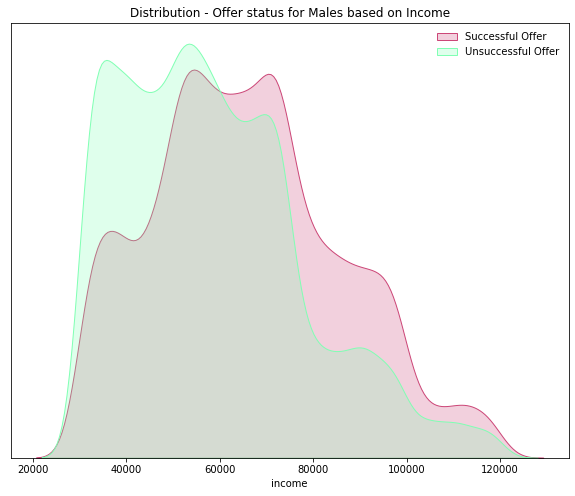

In [61]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_success_M, x="income", hue='success',fill=True,palette="plasma")
sns.kdeplot(data=df_failure_M, x="income", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Distribution - Offer status for Males based on Income');

### Visualize the counts

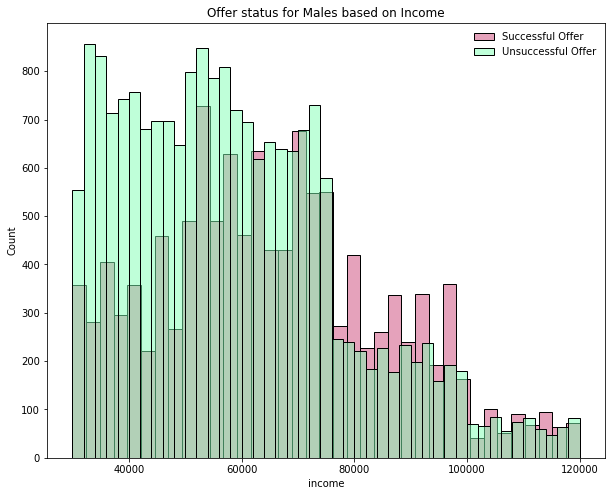

In [62]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_success_M, x="income", hue='success',fill=True,palette="plasma")
sns.histplot(data=df_failure_M, x="income", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(True)
plt.title('Offer status for Males based on Income');

# 3. Age

* Famales

In [63]:
success_rate_age_F = cat_counts(df_success_F,'age')
success_rate_age_F.sort_values('Count',ascending=False).head(10)

,age,Count,Perc
0,58,353,3.207924
1,53,319,2.898946
2,57,315,2.862595
3,63,306,2.780807
4,59,288,2.617230
5,62,279,2.535442
6,55,277,2.517266
7,52,277,2.517266
8,56,272,2.471828
9,64,270,2.453653


In [64]:
failure_age_income_F = cat_counts(df_failure_F,'age')
failure_age_income_F.sort_values('Count',ascending=False).head(10)

,age,Count,Perc
0,58,360,3.049814
1,57,342,2.897323
2,53,316,2.677059
3,51,312,2.643172
4,60,306,2.592342
5,59,301,2.549983
6,56,287,2.431379
7,62,285,2.414436
8,52,279,2.363606
9,55,276,2.338190


### Visulaize the Distribution

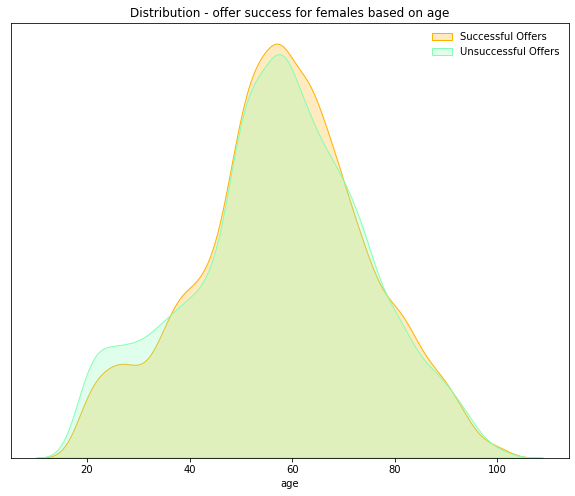

In [65]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_success_F, x="age", hue='success',fill=True,palette='prism_r')
sns.kdeplot(data=df_failure_F, x="age", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution - offer success for females based on age')
plt.gca().get_yaxis().set_visible(False);

### Visulaize the counts

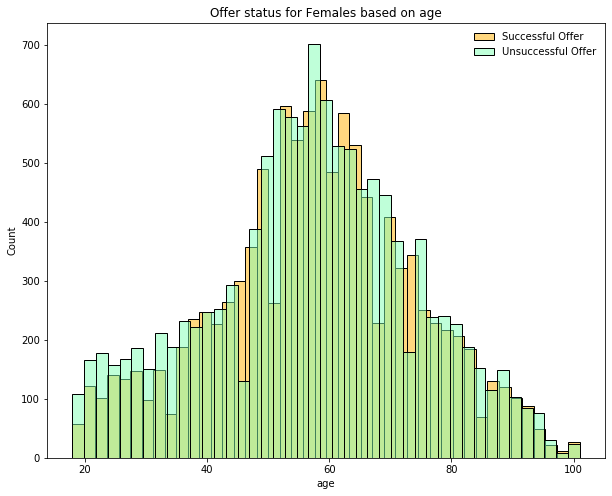

In [66]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_success_F, x="age", hue='success',fill=True,palette='prism_r')
sns.histplot(data=df_failure_F, x="age", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(True)
plt.title('Offer status for Females based on age');

* Males

In [67]:
success_rate_age_M = cat_counts(df_success_M,'age')
success_rate_age_M.sort_values('Count',ascending=False).head(10)

,age,Count,Perc
0,58,338,2.792927
1,55,332,2.743348
2,54,315,2.602876
3,53,307,2.536771
4,59,298,2.462403
5,51,297,2.454140
6,52,297,2.454140
7,57,293,2.421087
8,63,283,2.338456
9,60,283,2.338456


In [68]:
failure_age_income_M = cat_counts(df_failure_M,'age')
failure_age_income_M.sort_values('Count',ascending=False).head(10)

,age,Count,Perc
0,51,478,2.445889
1,58,477,2.440772
2,54,463,2.369135
3,56,448,2.292381
4,52,424,2.169575
5,60,420,2.149107
6,59,419,2.143990
7,53,419,2.143990
8,63,413,2.113289
9,61,411,2.103055


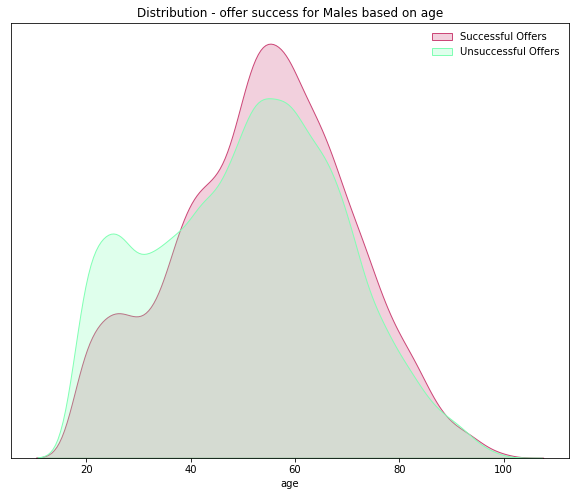

In [69]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_success_M, x="age", hue='success',fill=True,palette='plasma')
sns.kdeplot(data=df_failure_M, x="age", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution - offer success for Males based on age')
plt.gca().get_yaxis().set_visible(False);

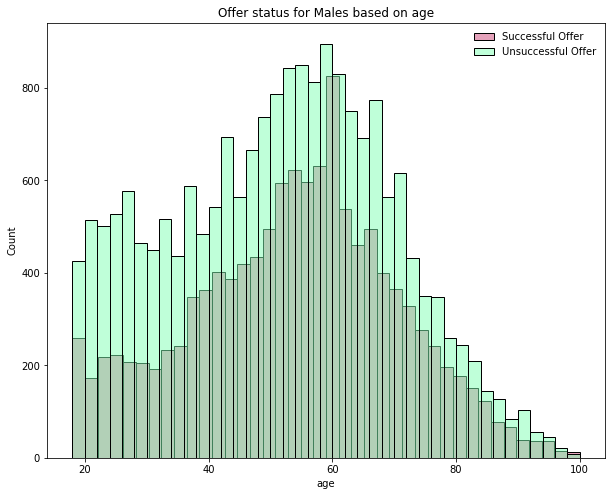

In [70]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_success_M, x="age", hue='success',fill=True,palette='plasma')
sns.histplot(data=df_failure_M, x="age", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(True)
plt.title('Offer status for Males based on age');

### Offer success and failure based on offer duration

In [71]:
success_rate_duartion = cat_counts(df_success,'duration')
success_rate_duartion.sort_values('Count',ascending=False)

,duration,Count,Perc
0,7,11607,49.393591
1,5,6286,26.750074
2,10,5606,23.856334


In [72]:
failure_rate_duartion = cat_counts(df_failure,'duration')
failure_rate_duartion.sort_values('Count',ascending=False)

,duration,Count,Perc
0,7,10486,33.054881
1,10,5526,17.419538
2,4,5524,17.413233
3,3,5517,17.391167
4,5,4670,14.721180


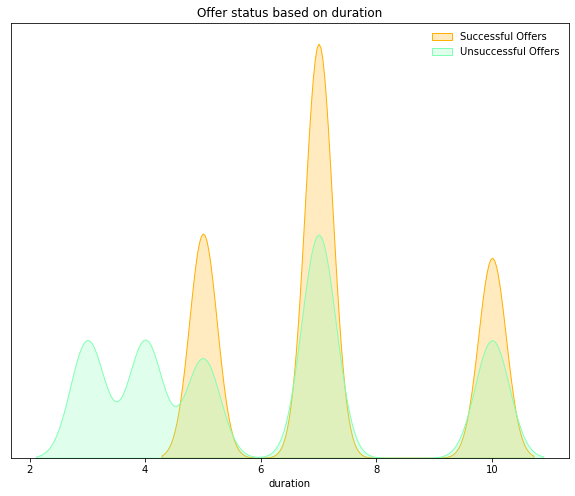

In [73]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_success, x="duration", hue='success',fill=True,palette='prism_r')
sns.kdeplot(data=df_failure, x="duration", hue='success',fill=True,palette='rainbow')
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Offer status based on duration')
plt.gca().get_yaxis().set_visible(False);

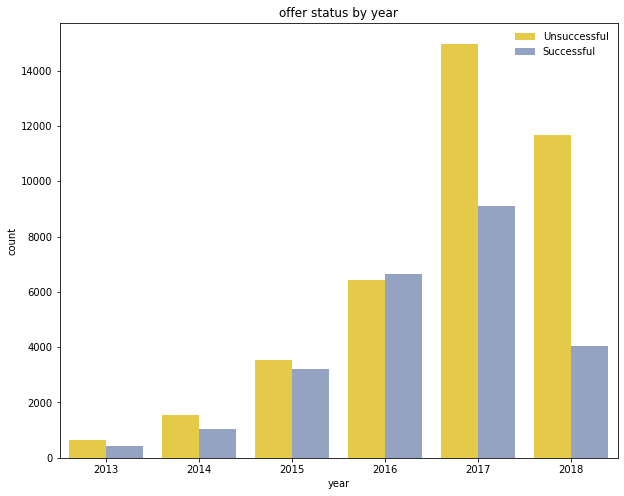

In [74]:
plt.figure(figsize=(10, 8))
sns.countplot(x='year',hue='success',data=df_all,palette='Set2_r');
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('offer status by year');

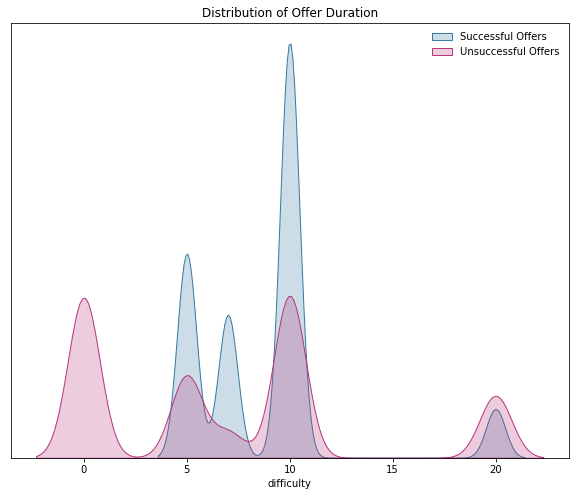

In [75]:
successful = df_all.loc[df_all['success'] == 1]
failure = df_all.loc[df_all['success'] == 0]
plt.figure(figsize=(10, 8))
sns.kdeplot(data=successful, x="difficulty", hue='success',fill=True,palette='mako_r')
sns.kdeplot(data=failure, x="difficulty", hue='success',fill=True,palette='magma_r')
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution of Offer Duration')
plt.gca().get_yaxis().set_visible(False);

# Model

In [76]:
df_all.head()

,customer_id,offer_id,success,difficulty,duration,offer_type,reward,email,mobile,social,web,age,gender,income,membership_start,year,month,membership_term
0,0009655768c64bdeb2e877511632db8f,Offer- 1,0.0,10,7,discount,2,1,1,0,1,33,M,72000.0,2017-04-21,2017,4,1532
1,0009655768c64bdeb2e877511632db8f,Offer- 2,0.0,0,4,informational,0,1,1,0,1,33,M,72000.0,2017-04-21,2017,4,1532
2,0009655768c64bdeb2e877511632db8f,Offer- 3,0.0,0,3,informational,0,1,1,1,0,33,M,72000.0,2017-04-21,2017,4,1532
3,0009655768c64bdeb2e877511632db8f,Offer- 4,1.0,5,5,bogo,5,1,1,1,1,33,M,72000.0,2017-04-21,2017,4,1532
4,0009655768c64bdeb2e877511632db8f,Offer- 5,1.0,10,10,discount,2,1,1,1,1,33,M,72000.0,2017-04-21,2017,4,1532


In [77]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 18 columns):
customer_id         63288 non-null object
offer_id            63288 non-null object
success             63288 non-null float64
difficulty          63288 non-null int64
duration            63288 non-null int64
offer_type          63288 non-null object
reward              63288 non-null int64
email               63288 non-null int64
mobile              63288 non-null int64
social              63288 non-null int64
web                 63288 non-null int64
age                 63288 non-null int64
gender              55222 non-null object
income              55222 non-null float64
membership_start    63288 non-null datetime64[ns]
year                63288 non-null int64
month               63288 non-null int64
membership_term     63288 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(11), object(4)
memory usage: 11.7+ MB


## How well does the offer and demographics information explain the outcome of the offer types Discount and BOGO?
* Offer type 1 = Discount
* Offer type 2 = Bogo
* Informational type is not a valid offer we skip it.

In [78]:
def generate_features(df,col1,item):
    '''
    Function creates features used in modelling.
    
    Input:
    df: DataFrame - Merged dataframe (df_all)
    
    Output:
    X:DataFrame - Explanatory variables used in predicting success or failure of an offer
    Y:DataFrame - Offer status (1 == Success and 0 == Failure)
    df: DataFrame - Transformed df_all with dummy variables for categorical and numeric features.
    '''
    # Define target offer type
    df = df[df[col1]==item].drop(col1,axis=1)
    
    # age = 118 is an outlier value, replace it with nan inorder to interpolate it.
    df['age'] = df['age'].apply(lambda x: np.nan if x ==118 else x)
    
    # fill in the missing values
    # fill missing age with the median age of the dataset
    df['age'] = df['age'].fillna(df['age'].median())
    
    # fill missing income with the mean income of the dataset
    df['income'] = df['income'].fillna(df['income'].mean())
    
    # create dummy variables for categorical variables
    cat_vars = df.drop(['customer_id'],axis=1).select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_')], axis=1)
        
    # Create dummy variables for numeric columns with limited classes
    num_vars = df[['difficulty','duration']].copy().columns
    for var in  num_vars:
         #for each num add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_')], axis=1)
    
    # Create the X and Y features.         
    X = df.drop(['customer_id','year','month','success','membership_start'], axis=1)
    Y = df['success']
    
    return X,Y,df 

## Model 1: Random Forest classifier

In [79]:
def mdl_rfc(X,Y):
    '''
    Function to split data,scale features, train, test, predict and 
    evaluate the performance of the Random Forest Classifier model.
    ----------------------------------------------------------------------------
    Input:
    X:DataFrame - Explanatory variables used in predicting success or failure of an offer 
    Y:DataFrame - Offer status (1 == Success and 0 == Failure)
    ---------------------------------------------------------------------------
    Output:
    X_train:DataFrame  - 70% of the X features for training and fitting the model
    X_test:DataFrame   - 30% of the X features for testing the model
    y_train:DataFrame  - 70% of the Y feature for training and fitting the model
    y_test:DataFrame   - 30% of the Y feature to be used in predicting witht the fitted model
    y_pred:DataFrame   - Results from predicting y_test with fitted model.
    coefs_df:DataFrame - Coffecients and their corresponding effect.
    '''
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state=42)
    
    # Rescale the features
    scaler = MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    # Define the model
    clf = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
    
    # Fit the model
    clf.fit(X_train,y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_test,y_pred)
    print('model accuracy_test: {}'.format(model_accuracy*100))
    
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Greens')
    plt.title('Confusion Matrix')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show();
    
    
    print(classification_report(y_test,y_pred))
    
    coefs_df = pd.DataFrame()

    coefs_df['coeff'] = X.columns
    coefs_df['coefs'] = clf.feature_importances_
    coefs_df['abs_coefs'] = np.abs(clf.feature_importances_)

    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    coefs_df
    
    return X_train, X_test, y_train, y_test, y_pred,coefs_df,model_accuracy,clf

## Offer type 1
* offer_type == discount

In [80]:
X_1,Y_1,df_all_col1 = generate_features(df_all,'offer_type','discount')

In [81]:
df_all_col1.head()

,customer_id,success,reward,email,mobile,social,web,age,income,membership_start,...,offer_id_Offer- 6,offer_id_Offer- 7,gender_F,gender_M,gender_O,difficulty_7,difficulty_10,difficulty_20,duration_7,duration_10
0,0009655768c64bdeb2e877511632db8f,0.0,2,1,1,0,1,33.0,72000.0,2017-04-21,...,0,0,0,1,0,0,1,0,1,0
4,0009655768c64bdeb2e877511632db8f,1.0,2,1,1,1,1,33.0,72000.0,2017-04-21,...,0,0,0,1,0,0,1,0,0,1
6,0011e0d4e6b944f998e987f904e8c1e5,1.0,5,1,0,0,1,40.0,57000.0,2018-01-09,...,1,0,0,0,1,0,0,1,0,1
7,0011e0d4e6b944f998e987f904e8c1e5,1.0,3,1,1,1,1,40.0,57000.0,2018-01-09,...,0,1,0,0,1,1,0,0,1,0
14,0020c2b971eb4e9188eac86d93036a77,1.0,2,1,1,1,1,59.0,90000.0,2016-03-04,...,0,0,1,0,0,0,1,0,0,1


In [82]:
X_1.head()

,reward,email,mobile,social,web,age,income,membership_term,offer_id_Offer- 1,offer_id_Offer- 5,offer_id_Offer- 6,offer_id_Offer- 7,gender_F,gender_M,gender_O,difficulty_7,difficulty_10,difficulty_20,duration_7,duration_10
0,2,1,1,0,1,33.0,72000.0,1532,1,0,0,0,0,1,0,0,1,0,1,0
4,2,1,1,1,1,33.0,72000.0,1532,0,1,0,0,0,1,0,0,1,0,0,1
6,5,1,0,0,1,40.0,57000.0,1269,0,0,1,0,0,0,1,0,0,1,0,1
7,3,1,1,1,1,40.0,57000.0,1269,0,0,0,1,0,0,1,1,0,0,1,0
14,2,1,1,1,1,59.0,90000.0,1945,0,1,0,0,1,0,0,0,1,0,0,1


## check balance in the classes

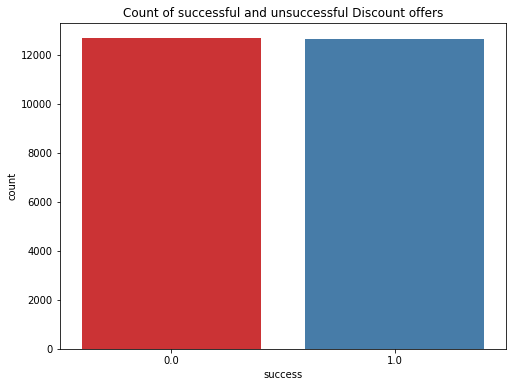

In [83]:
plt.figure(figsize=(8,6))
sns.countplot(df_all_col1['success'],palette='Set1')
plt.title('Count of successful and unsuccessful Discount offers');

model accuracy_test: 71.15207373271889


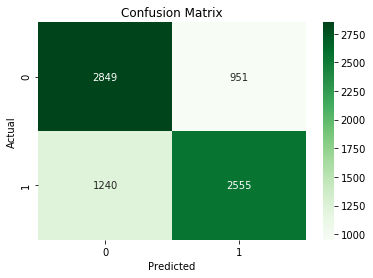

              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72      3800
         1.0       0.73      0.67      0.70      3795

    accuracy                           0.71      7595
   macro avg       0.71      0.71      0.71      7595
weighted avg       0.71      0.71      0.71      7595



In [84]:
X_train_1, X_test_1, y_train_1, y_test_1, y_pred_1, coefs_df,rfc_accuracy_1 ,clf_1 = mdl_rfc(X_1,Y_1)

In [85]:
clf_1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Coefficient importance

In [86]:
coefs_df.head(6)

,coeff,coefs,abs_coefs
7,membership_term,0.384518,0.384518
6,income,0.235257,0.235257
5,age,0.215294,0.215294
3,social,0.045727,0.045727
0,reward,0.026785,0.026785
2,mobile,0.016461,0.016461


### visualize feature importance

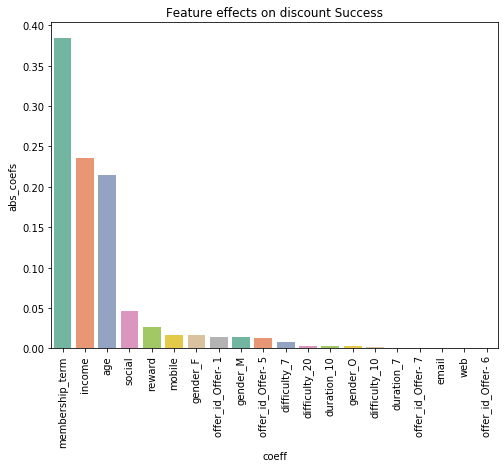

In [87]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data = coefs_df, x = "coeff", y = 'abs_coefs',palette='Set2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Feature effects on discount Success');

## Offer type 2
* Bogo

In [88]:
X_2,Y_2,df_all_col2 = generate_features(df_all,'offer_type','bogo')

### check for imbalance in the classes

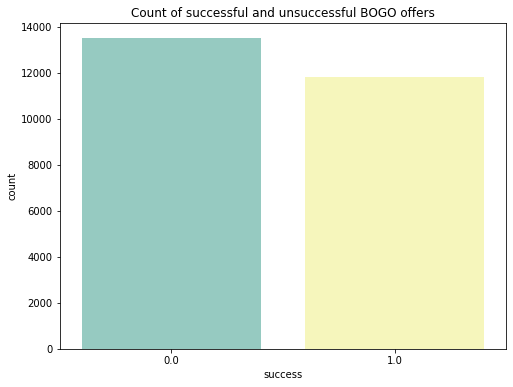

In [89]:
plt.figure(figsize=(8,6))
sns.countplot(df_all_col2['success'],palette='Set3')
plt.title('Count of successful and unsuccessful BOGO offers');

model accuracy_test: 67.47400289587995


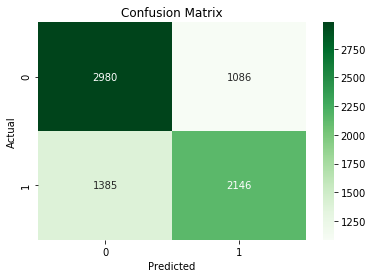

              precision    recall  f1-score   support

         0.0       0.68      0.73      0.71      4066
         1.0       0.66      0.61      0.63      3531

    accuracy                           0.67      7597
   macro avg       0.67      0.67      0.67      7597
weighted avg       0.67      0.67      0.67      7597



In [90]:
X_train, X_test, y_train, y_test, y_pred, coefs_df_2,rfc_accuracy_2,clf_2 = mdl_rfc(X_2,Y_2)

In [91]:
clf_2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [92]:
coefs_df_2.head(6)

,coeff,coefs,abs_coefs
7,membership_term,0.407685,0.407685
6,income,0.280173,0.280173
5,age,0.245123,0.245123
12,gender_F,0.024385,0.024385
13,gender_M,0.013667,0.013667
9,offer_id_Offer- 4,0.006795,0.006795


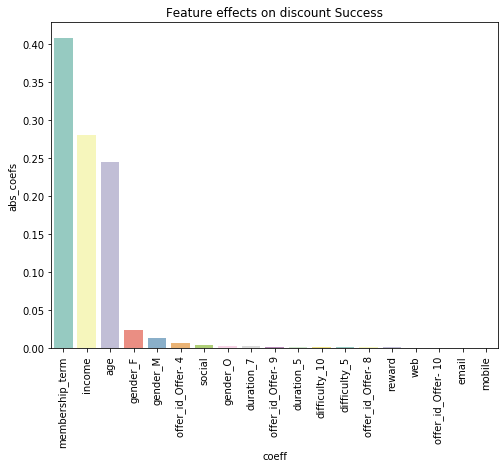

In [93]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data = coefs_df_2, x = "coeff", y = 'abs_coefs',palette='Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Feature effects on discount Success');

## Model 2 : Random forest classifier with GRID search

In [94]:
def optimal_mdl_rfc(X,Y):
    '''
    Function to split data,scale features,performs grid search for the most optimal parameters,
    train, test, predict and evaluate the performance of the optimal Random Forest Classifier model.
    ----------------------------------------------------------------------------
    Input:
    X:DataFrame - Explanatory variables used in predicting success or failure of an offer 
    Y:DataFrame - Offer status (1 == Success and 0 == Failure)
    ---------------------------------------------------------------------------
    Output:
    X_train:DataFrame  - 70% of the X features for training and fitting the model
    X_test:DataFrame   - 30% of the X features for testing the model
    y_train:DataFrame  - 70% of the Y feature for training and fitting the model
    y_test:DataFrame   - 30% of the Y feature to be used in predicting witht the fitted model
    y_pred:DataFrame   - Results from predicting y_test with fitted model.
    coefs_df:DataFrame - Coffecients and their corresponding effect.
    '''    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state=42)
    
    # Rescale the features
    scaler = MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    # Define the model
    rfc=RandomForestClassifier(random_state=42)
    
    # Specify parameter for gridsearch
    param_grid = { 'n_estimators': [100, 200],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : [4,5,6,7,8],
                    'criterion' :['gini', 'entropy']}
    
    # Initial the gridsearch
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    
    # Fit the model
    CV_rfc.fit(X_train, y_train)
    
    #best parameters
    best_parameters = CV_rfc.best_params_
    
    # Redefine the model with the best parameters.
    rfc_best=RandomForestClassifier(random_state=42, max_features=CV_rfc.best_params_['max_features'],
                                    n_estimators= CV_rfc.best_params_['n_estimators'], max_depth=CV_rfc.best_params_['max_depth'], 
                                    criterion=CV_rfc.best_params_['criterion'])
    
    # Fit the best model
    rfc_best.fit(X_train, y_train)
    
    # Make predictions with the optimal model
    y_pred=rfc_best.predict(X_test)
    
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_test,y_pred)
    print('model accuracy_test: {}'.format(model_accuracy*100))
    
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Reds')
    plt.title('Confusion Matrix')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show();
    
    
    print(classification_report(y_test,y_pred))
    
    coefs_df = pd.DataFrame()

    coefs_df['coeff'] = X.columns
    coefs_df['coefs'] = rfc_best.feature_importances_
    coefs_df['abs_coefs'] = np.abs(rfc_best.feature_importances_)

    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    coefs_df
    
    return coefs_df,model_accuracy,best_parameters

## Offer_type 1
* Discount

model accuracy_test: 73.73271889400922


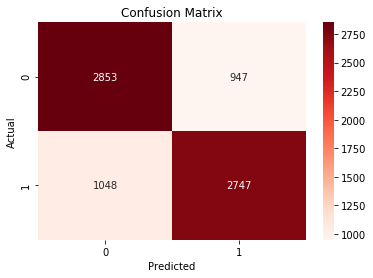

              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74      3800
         1.0       0.74      0.72      0.73      3795

    accuracy                           0.74      7595
   macro avg       0.74      0.74      0.74      7595
weighted avg       0.74      0.74      0.74      7595



In [95]:
optcoefs_df, rfc_accuracy_3,best_parameters_1= optimal_mdl_rfc(X_1,Y_1)

In [96]:
best_parameters_1

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [97]:
optcoefs_df.head(6)

,coeff,coefs,abs_coefs
7,membership_term,0.253256,0.253256
6,income,0.148419,0.148419
3,social,0.120250,0.120250
5,age,0.087331,0.087331
17,difficulty_20,0.051195,0.051195
12,gender_F,0.048529,0.048529


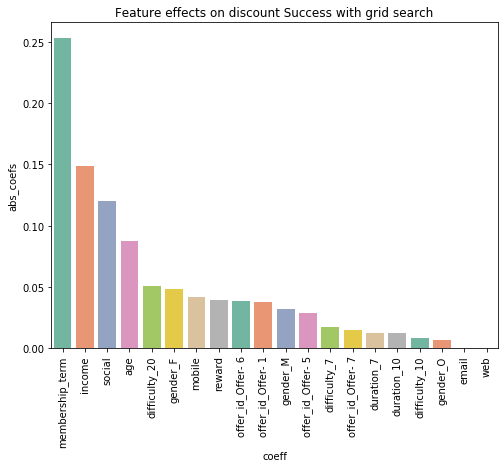

In [98]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data = optcoefs_df, x = "coeff", y = 'abs_coefs',palette='Set2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Feature effects on discount Success with grid search');

## Offer_type 2

model accuracy_test: 71.44925628537581


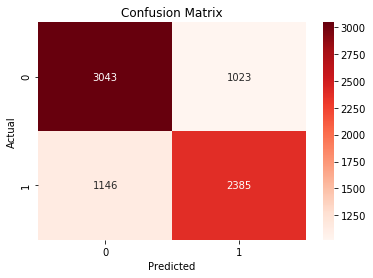

              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74      4066
         1.0       0.70      0.68      0.69      3531

    accuracy                           0.71      7597
   macro avg       0.71      0.71      0.71      7597
weighted avg       0.71      0.71      0.71      7597



In [99]:
optcoefs_df2,rfc_accuracy_4,best_parameters_2 = optimal_mdl_rfc(X_2,Y_2)

In [100]:
best_parameters_2

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [101]:
optcoefs_df2.head(6)

,coeff,coefs,abs_coefs
6,income,0.303061,0.303061
7,membership_term,0.292050,0.292050
5,age,0.130495,0.130495
12,gender_F,0.097683,0.097683
13,gender_M,0.066131,0.066131
9,offer_id_Offer- 4,0.023760,0.023760


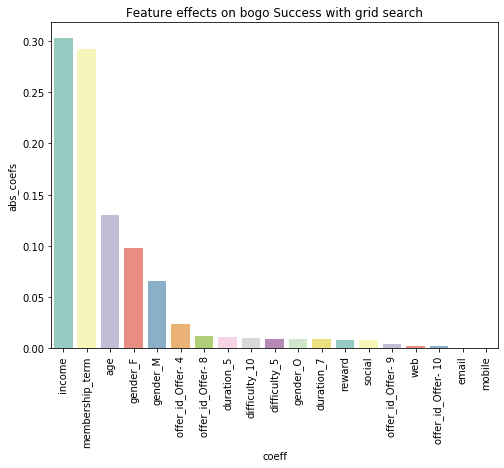

In [102]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data = optcoefs_df2, x = "coeff", y = 'abs_coefs',palette='Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Feature effects on bogo Success with grid search');

# Model 3:  Support Vector Classifier (SVC)

In [103]:
def mdl_svc(X,Y):
    '''
    Function to split data,scale features, train, test, predict and 
    evaluate the performance of the Support Vector Machine model.
    ----------------------------------------------------------------------------
    Input:
    X:DataFrame - Explanatory variables used in predicting success or failure of an offer 
    Y:DataFrame - Offer status (1 == Success and 0 == Failure)
    ---------------------------------------------------------------------------
    Output:
    X_train:DataFrame  - 70% of the X features for training and fitting the model
    X_test:DataFrame   - 30% of the X features for testing the model
    y_train:DataFrame  - 70% of the Y feature for training and fitting the model
    y_test:DataFrame   - 30% of the Y feature to be used in predicting witht the fitted model
    y_pred:DataFrame   - Results from predicting y_test with fitted model.
    coefs_df:DataFrame - Coffecients and their corresponding effect.
    '''
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state=42)
    
    # Rescale the features
    scaler = StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    # Define the model
    clf = SVC()
    
    # Fit the model
    clf.fit(X_train,y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_test,y_pred)
    print('model accuracy_test: {}'.format(model_accuracy*100))
    
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show();
    
    
    print(classification_report(y_test,y_pred))
    
    
    return X_train, X_test, y_train, y_test, y_pred,model_accuracy,clf

## Offer_type 1
* Discount

model accuracy_test: 72.73206056616195


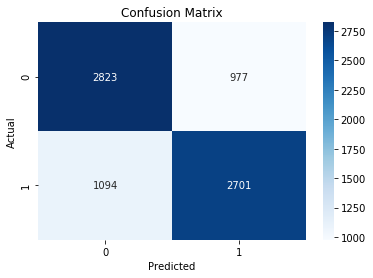

              precision    recall  f1-score   support

         0.0       0.72      0.74      0.73      3800
         1.0       0.73      0.71      0.72      3795

    accuracy                           0.73      7595
   macro avg       0.73      0.73      0.73      7595
weighted avg       0.73      0.73      0.73      7595



In [104]:
X_train, X_test, y_train, y_test, y_pred,svc_accuracy_1,clf_3 = mdl_svc(X_1,Y_1)

In [105]:
clf_3

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Offer_type 2
* Bogo

model accuracy_test: 70.6726339344478


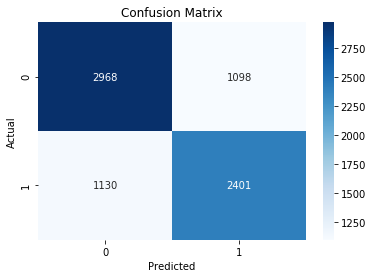

              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73      4066
         1.0       0.69      0.68      0.68      3531

    accuracy                           0.71      7597
   macro avg       0.71      0.70      0.71      7597
weighted avg       0.71      0.71      0.71      7597



In [106]:
X_train, X_test, y_train, y_test, y_pred,svc_accuracy_2,clf_4 = mdl_svc(X_2,Y_2)

In [107]:
clf_4 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Model 4: Support Vector Classifier (SVC) with Grid search

In [108]:
def optimal_mdl_svc(X,Y):
    '''
    Function to split data,scale features,performs grid search for the most optimal parameters,
    train, test, predict and evaluate the performance of the optimal Support Vector Machine model.
    ----------------------------------------------------------------------------
    Input:
    X:DataFrame - Explanatory variables used in predicting success or failure of an offer 
    Y:DataFrame - Offer status (1 == Success and 0 == Failure)
    ---------------------------------------------------------------------------
    Output:
    X_train:DataFrame  - 70% of the X features for training and fitting the model
    X_test:DataFrame   - 30% of the X features for testing the model
    y_train:DataFrame  - 70% of the Y feature for training and fitting the model
    y_test:DataFrame   - 30% of the Y feature to be used in predicting witht the fitted model
    y_pred:DataFrame   - Results from predicting y_test with fitted model.
    coefs_df:DataFrame - Coffecients and their corresponding effect.
    '''    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state=42)
    
    # Rescale the features
    scaler = StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    
    # Specify parameter for gridsearch
    param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
    
    # Initial the gridsearch and define the model
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
    
    # Fit the model
    grid.fit(X_train, y_train)
    
    # Best parameters
    best_parameters = grid.best_params_
    
    # Make predictions with the optimal model
    y_pred = grid.predict(X_test)
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_test,y_pred)
    print('model accuracy_test: {}'.format(model_accuracy*100))
    
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Purples')
    plt.title('Confusion Matrix')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show();
    
    
    print(classification_report(y_test,y_pred))
    
    
    return  X_train, X_test, y_train, y_test, y_pred,model_accuracy,best_parameters

## Offer_type 1
* Discount

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.730, total=   6.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.736, total=   6.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.735, total=   6.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.725, total=   7.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.723, total=   8.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.725, total=   6.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.693, total=   6.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.700, total=   6.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.695, total=   6.3s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.682, total= 3.8min
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.692, total= 3.9min
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.699, total= 4.0min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.732, total= 3.2min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.733, total= 2.9min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.738, total= 2.9min
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.736, total=  39.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 35.8min finished


model accuracy_test: 73.56155365371954


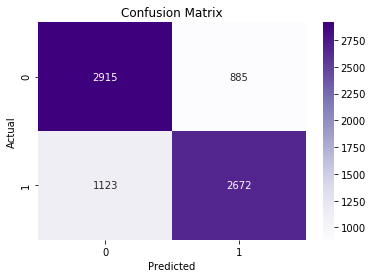

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74      3800
         1.0       0.75      0.70      0.73      3795

    accuracy                           0.74      7595
   macro avg       0.74      0.74      0.74      7595
weighted avg       0.74      0.74      0.74      7595



In [109]:
X_train, X_test, y_train, y_test, y_pred,svc_accuracy_3,best_parameters_3 = optimal_mdl_svc(X_1,Y_1)

In [110]:
best_parameters_3

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

## Offer_type 2
* Bogo

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.697, total=   8.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.700, total=   8.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.694, total=  10.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.681, total=   9.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.687, total=   8.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.688, total=   7.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.671, total=   7.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.672, total=   8.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.678, total=   7.9s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.660, total= 5.7min
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.669, total= 5.7min
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.657, total= 6.7min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.700, total= 1.5min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.697, total= 1.7min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.693, total= 1.4min
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.698, total=  18.5s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 36.4min finished


model accuracy_test: 70.61998157167302


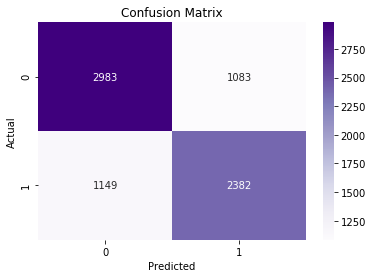

              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73      4066
         1.0       0.69      0.67      0.68      3531

    accuracy                           0.71      7597
   macro avg       0.70      0.70      0.70      7597
weighted avg       0.71      0.71      0.71      7597



In [111]:
X_train, X_test, y_train, y_test, y_pred,svc_accuracy_4,best_parameters_4 = optimal_mdl_svc(X_2,Y_2)

In [112]:
best_parameters_4

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [113]:
svc_accuracy_4

0.7061998157167303

# Model performance
* Analyse how the models have performed when predicting the offer outcomes

### 1 . Offer type 1 = Discount

In [114]:
accuracy = np.array([rfc_accuracy_1,rfc_accuracy_3,svc_accuracy_1,svc_accuracy_3]).reshape(-1,1)
metrics = pd.DataFrame(accuracy,columns=['Accuracy'])

model_names = np.array(['RFC','RFC_grid','SVC','SVC_grid']).reshape(-1,1)

metrics = pd.concat([metrics,pd.DataFrame(model_names)],axis=1)

metrics.columns = ['Accuracy_Discount','Models']

metrics.set_index('Models').sort_values(by='Accuracy_Discount',ascending=False)

,Accuracy_Discount
Models,
RFC_grid,0.737327
SVC_grid,0.735616
SVC,0.727321
RFC,0.711521


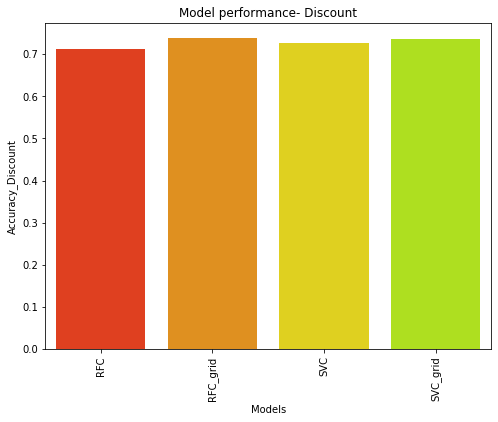

In [115]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data = metrics, x = "Models", y = 'Accuracy_Discount',palette='prism')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Model performance- Discount');

## 2. Offer type 2 = Bogo

In [116]:
accuracy2 = np.array([rfc_accuracy_2,rfc_accuracy_4,svc_accuracy_2,svc_accuracy_4]).reshape(-1,1)
metrics2 = pd.DataFrame(accuracy2,columns=['Accuracy'])

model_names = np.array(['RFC','RFC_grid','SVC','SVC_grid']).reshape(-1,1)

metrics_2 = pd.concat([metrics2,pd.DataFrame(model_names)],axis=1)

metrics_2.columns = ['Accuracy_BOGO','Models']

metrics_2.set_index('Models').sort_values(by='Accuracy_BOGO',ascending=False)

,Accuracy_BOGO
Models,
RFC_grid,0.714493
SVC,0.706726
SVC_grid,0.706200
RFC,0.674740


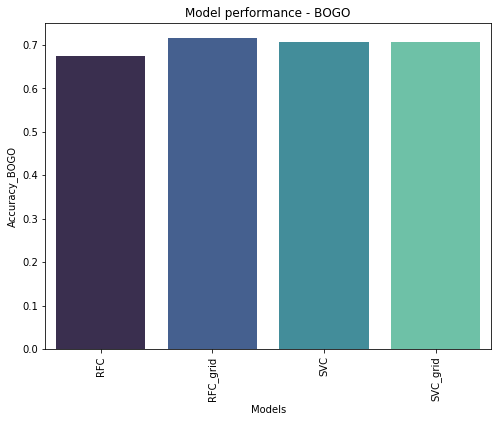

In [117]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data = metrics_2, x = "Models", y = 'Accuracy_BOGO',palette='mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Model performance - BOGO');